This notebook is just the code from The Annotated Transformer, included here as a baseline for comparison with head_normalized_annotated_transformer.ipynb

In [1]:
# !python -m spacy download en
# !python -m spacy download de

In [2]:
# %pip install torchtext
# %pip install sacrebleu

In [3]:
import numpy as np
import torch
import spacy
import sacrebleu
import pickle
import torch.nn as nn
import torch.nn.functional as F
import math, copy
import matplotlib.pyplot as plt
import seaborn
from torch.autograd import Variable
from torch.nn import Parameter
from torchtext import data, datasets
from nltk.tokenize.treebank import TreebankWordDetokenizer
seaborn.set_context(context="talk")


%matplotlib inline

In [4]:
MAX_LEN = 50
MIN_FREQ = 1
BATCH_SIZE = 4096

In [5]:
global max_src_in_batch, max_tgt_in_batch



def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

def make_std_mask(src, tgt, pad):
    src_mask = (src != pad).unsqueeze(-2)
    tgt_mask = (tgt != pad).unsqueeze(-2)
    tgt_mask = tgt_mask & Variable(subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
    return src_mask, tgt_mask

    
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

    
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2
    
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity we apply the norm first as opposed to last.
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer function that maintains the same size."
        return x + self.dropout(sublayer(self.norm(x)))
    

class Encoder(nn.Module):
    "Core encoder is a stack of N layers"
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)
       
    
    
class EncoderLayer(nn.Module):
    "Encoder is made up of two sublayers, self-attn and feed forward (defined below)"
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        "Follow Figure 1 (left) for connections."
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)
    
class Decoder(nn.Module):
    "Generic N layer decoder with masking."
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)
    
class DecoderLayer(nn.Module):
    "Decoder is made up of three sublayers, self-attn, src-attn, and feed forward (defined below)"
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
 
    def forward(self, x, memory, src_mask, tgt_mask):
        "Follow Figure 1 (right) for connections."
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)
    
    
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many 
    other models.
    """
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator

        
    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        return self.decode(self.encode(src, src_mask), src_mask,
                            tgt, tgt_mask)
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)
    
    




def attention(query, key, value, mask=None, dropout=0.0):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    # (Dropout described below)
    p_attn = F.dropout(p_attn, p=dropout)
    return torch.matmul(p_attn, value), p_attn

class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.p = dropout
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        
    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        query, key, value = [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
                             for l, x in zip(self.linears, (query, key, value))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, key, value, mask=mask, dropout=self.p)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)
    
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        # Torch linears have a `b` by default. 
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))
    
    
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)
    
    
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)
        return self.dropout(x)
    
class Generator(nn.Module):
    "Standard generation step. (Not described in the paper.)"
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)
    
    
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup**(-1.5)))
        
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

class LabelSmoothing(nn.Module):
    "Implement label smoothing."
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))
    
    
def loss_backprop(generator, criterion, out, targets, normalize):
    """
    Memory optmization. Compute each timestep separately and sum grads.
    """
    assert out.size(1) == targets.size(1)
    total = 0.0
    out_grad = []
    for i in range(out.size(1)):
        out_column = Variable(out[:, i].data, requires_grad=True)
        gen = generator(out_column)
        loss = criterion(gen, targets[:, i]) / normalize
        total += loss.data.item()
        loss.backward()
        out_grad.append(out_column.grad.data.clone())
    out_grad = torch.stack(out_grad, dim=1)
    out.backward(gradient=out_grad)
    return total



def train_epoch(train_iter, model, criterion, model_opt, transpose=False):
    model.train()
    for i, batch in enumerate(train_iter):
        src, trg, src_mask, trg_mask = \
            batch.src, batch.trg, batch.src_mask, batch.trg_mask
        
        out = model.forward(src, trg[:, :-1], src_mask, trg_mask[:, :-1, :-1])
        loss = loss_backprop(model.generator, criterion, out, trg[:, 1:], batch.ntokens) 
                        
        model_opt.step()
        model_opt.optimizer.zero_grad()
       # model_opt.zero_grad()
        if i % 10 == 1:
            print(i, loss)
            
            
def valid_epoch(valid_iter, model, criterion, transpose=False):
    model.eval()
    total = 0
    vals = []
    for batch in valid_iter:
        src, trg, src_mask, trg_mask = \
            batch.src, batch.trg, batch.src_mask, batch.trg_mask
        out = model.forward(src, trg[:, :-1], src_mask, trg_mask[:, :-1, :-1])
        loss = loss_backprop(model.generator, criterion, out, trg[:, 1:], batch.ntokens)
        vals.append(loss)
    print('validation loss: {}'.format(np.mean(vals)))
        
class Batch:
    def __init__(self, src, trg, src_mask, trg_mask, ntokens):
        self.src = src
        self.trg = trg
        self.src_mask = src_mask
        self.trg_mask = trg_mask
        self.ntokens = ntokens
    
def data_gen(V, batch, nbatches):
    for i in range(nbatches):
        data = torch.from_numpy(np.random.randint(1, V, size=(batch, 10)))
        src = Variable(data, requires_grad=False)
        src = src.type(torch.long)
        tgt = Variable(data, requires_grad=False)
        tgt = tgt.type(torch.long)
        src_mask, tgt_mask = make_std_mask(src, tgt, 0)
        yield Batch(src, tgt, src_mask, tgt_mask, (tgt[1:] != 0).data.sum())
        
def batch_size_fn(new, count, sofar):
    "Keep augmenting batch and calculate total number of tokens + padding."
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    max_src_in_batch = max(max_src_in_batch,  len(new.src))
    max_tgt_in_batch = max(max_tgt_in_batch,  len(new.trg) + 2)
    src_elements = count * max_src_in_batch
    tgt_elements = count * max_tgt_in_batch
    return max(src_elements, tgt_elements)

class MyIterator(data.Iterator):
    def create_batches(self):
        if self.train:
            def pool(d, random_shuffler):
                for p in data.batch(d, self.batch_size * 100):
                    p_batch = data.batch(
                        sorted(p, key=self.sort_key),
                        self.batch_size, self.batch_size_fn)
                    for b in random_shuffler(list(p_batch)):
                        yield b
            self.batches = pool(self.data(), self.random_shuffler)
            
        else:
            self.batches = []
            for b in data.batch(self.data(), self.batch_size,
                                          self.batch_size_fn):
                self.batches.append(sorted(b, key=self.sort_key))

def rebatch(pad_idx, batch):
    "Fix order in torchtext to match ours"
    src, trg = batch.src.transpose(0, 1), batch.trg.transpose(0, 1)
    src_mask, trg_mask = make_std_mask(src, trg, pad_idx)
    return Batch(src, trg, src_mask, trg_mask, (trg[1:] != pad_idx).data.sum())


def tokenize_de(text):
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]


def make_model(src_vocab, tgt_vocab, N=6, d_model=512.0, d_ff=2048, h=8, dropout=0.1):
    "Construct a model object based on hyperparameters."
    c = copy.deepcopy
    d_model = int(d_model)
    attn = MultiHeadedAttention(h, d_model, dropout)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab))
    
    # This was important from their code. Initialize parameters with Glorot or fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)
    return model

def greedy_decode(model, src, src_mask, max_len, start_symbol):
    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)
    for i in range(max_len-1):
        out = model.decode(memory, src_mask, 
                           Variable(ys), 
                           Variable(subsequent_mask(ys.size(1))
                                    .type_as(src.data)))
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.data[0]
        ys = torch.cat([ys, 
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
    return ys

def translate(sent):
    src = torch.LongTensor([[SRC.vocab.stoi[w] for w in sent]])
    src = src.to(device)
    src_mask = (src != SRC.vocab.stoi["<blank>"]).unsqueeze(-2)
    out = greedy_decode(model, src, src_mask, 
                        max_len=int(MAX_LEN), start_symbol=TGT.vocab.stoi["<s>"])
    trans = "<s> "
    for i in range(1, out.size(1)):
        sym = TGT.vocab.itos[out[0, i]]
        if sym == "</s>": break
        trans += sym + " "
    return trans.replace('<s>','').strip()


def draw(data, x, y, ax):
    seaborn.heatmap(data, 
                    xticklabels=x, square=True, yticklabels=y, vmin=0.0, vmax=1.0, 
                    cbar=False, ax=ax)

In [6]:
# Load words from IWSLT

#!pip install torchtext spacy
#!python -m spacy download en
#!python -m spacy download de

spacy_de = spacy.load('de')
spacy_en = spacy.load('en')


BOS_WORD = '<s>'
EOS_WORD = '</s>'
BLANK_WORD = "<blank>"
SRC = data.Field(tokenize=tokenize_de, pad_token=BLANK_WORD)
TGT = data.Field(tokenize=tokenize_en, init_token = BOS_WORD, 
                 eos_token = EOS_WORD, pad_token=BLANK_WORD)

train, val, test = datasets.IWSLT.splits(exts=('.de', '.en'), fields=(SRC, TGT), 
                                         filter_pred=lambda x: len(vars(x)['src']) <= MAX_LEN and 
                                         len(vars(x)['trg']) <= MAX_LEN)

SRC.build_vocab(train.src, min_freq=MIN_FREQ)
TGT.build_vocab(train.trg, min_freq=MIN_FREQ)


device = torch.device('cuda:0')

train_iter = MyIterator(train, batch_size=BATCH_SIZE, device=device,
                        repeat=False, sort_key=lambda x: (len(x.src), len(x.trg)),
                        batch_size_fn=batch_size_fn, train=True)
valid_iter = MyIterator(val, batch_size=BATCH_SIZE, device=device,
                        repeat=False, sort_key=lambda x: (len(x.src), len(x.trg)),
                        batch_size_fn=batch_size_fn, train=False)

pad_idx = TGT.vocab.stoi["<blank>"]

In [7]:
model = make_model(len(SRC.vocab), len(TGT.vocab), N=6, d_model=512, d_ff=2048, h=8, dropout=0.1)
model_opt = get_std_opt(model)
model.cuda()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:417: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


EncoderDecoder(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0): Linear(in_features=512, out_features=512, bias=True)
            (1): Linear(in_features=512, out_features=512, bias=True)
            (2): Linear(in_features=512, out_features=512, bias=True)
            (3): Linear(in_features=512, out_features=512, bias=True)
          )
        )
        (feed_forward): PositionwiseFeedForward(
          (w_1): Linear(in_features=512, out_features=2048, bias=True)
          (w_2): Linear(in_features=2048, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (sublayer): ModuleList(
          (0): SublayerConnection(
            (norm): LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): SublayerConnection(
            (norm): LayerNorm()
            (dropout): Dropout(p=0.1, inplace=Fals

In [8]:
criterion = LabelSmoothing(size=len(TGT.vocab), padding_idx=pad_idx, smoothing=0.1)
criterion.cuda()
for epoch in range(10):
    train_epoch((rebatch(pad_idx, b) for b in train_iter), model, criterion, model_opt)
    valid_epoch((rebatch(pad_idx, b) for b in valid_iter), model, criterion)

/opt/conda/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


1 8.947835743427277
11 9.195998221635818
21 8.697071969509125
31 9.186648902483284
41 9.020151294767857
51 8.416922613978386
61 8.527339935302734
71 8.40283077955246
81 8.47580437362194
91 8.008203029632568
101 7.872047424316406
111 7.505422115325928
121 7.5890775471925735
131 7.201697438955307
141 7.056632459163666
151 6.8102763295173645
161 5.900777816772461
171 6.358431234955788
181 5.234269035747275
191 6.134348575025797
201 5.9515857100486755
211 5.817536190152168
221 4.929892748594284
231 5.110749065876007
241 5.463914953172207
251 5.499077968299389
261 3.6468609685543925
271 5.610549367964268
281 5.523954010102898
291 5.294303335249424
301 5.487431735731661
311 5.553790770471096
321 4.9218289609998465
331 4.436470717191696
341 5.236650330945849
351 5.4174696679692715
361 4.6699692122638226
371 5.451190741034225
381 5.213411679491401
391 4.836031545884907
401 5.089491973165423
411 4.766223589889705
421 4.7386838835373055
431 4.788673537783325
441 4.596254501491785
451 5.193377667

In [10]:
torch.save(model.state_dict(), 'sdpa_annotated_transformer')

In [11]:
model.eval()
german = [i for i in test.src]
english = [i for i in test.trg]
reference = [' '.join(s).strip() for s in english]
candidates = []
for g in german:
    candidates.append(translate(g))

candidates = [TreebankWordDetokenizer().detokenize([c]) for c in candidates]
reference =  [TreebankWordDetokenizer().detokenize([c]) for c in reference]

In [12]:
fn = open('baseline_candidates.pkl', 'wb')
pickle.dump(candidates, fn)
fn.close()

fn = open('baseline_reference.pkl', 'wb')
pickle.dump(reference, fn)
fn.close()

In [14]:
bleu = sacrebleu.corpus_bleu(candidates, [reference])
print('{} BLEU'.format(bleu.score))

19.396893780567478 BLEU


In [15]:
for i, batch in enumerate(valid_iter):
    while i < 5:
        src = batch.src.transpose(0, 1)[:1]
        src_mask = (src != SRC.vocab.stoi["<blank>"]).unsqueeze(-2)
        out = greedy_decode(model, src, src_mask, 
                            max_len=60, start_symbol=TGT.vocab.stoi["<s>"])
        print("Translation:", end="\t")
        for i in range(1, out.size(1)):
            sym = TGT.vocab.itos[out[0, i]]
            if sym == "</s>": break
            print(sym, end =" ")
        print()
        print("Target:", end="\t")
        for i in range(1, batch.trg.size(0)):
            sym = TGT.vocab.itos[batch.trg.data[i, 0]]
            if sym == "</s>": break
            print(sym, end =" ")
        print('\n')
#     break
        

Translation:	So I planted a food kit in front of my house . 
Target:	So what I did , I planted a food forest in front of my house . 

Translation:	You can see the central characters , who are the group of leaders . 
Target:	You can see the hubs , like who are the leaders in the group . 

Translation:	And I said , " I do n't know , that 's not in my responsibility . " 
Target:	And the first answer is , " I do n't know , they do n't put me in charge of that . " 

Translation:	Over four decades , today , the offshore regime and infrastructure and the moral structure has destroyed society , and the moral structure of the society . 
Target:	For four decades Gaddafi 's tyrannical regime destroyed the infrastructure as well as the culture and the moral fabric of Libyan society . 

Translation:	I was just three years old when my brother was born , and I was so excited that I had a new living in my life . 
Target:	I was just three years old when my brother came along , and I was so excited that

Translation:	<s> I was just three years old , when my brother was born , and I was so excited that I had a new creature in my life . 
Encoder Layer 2


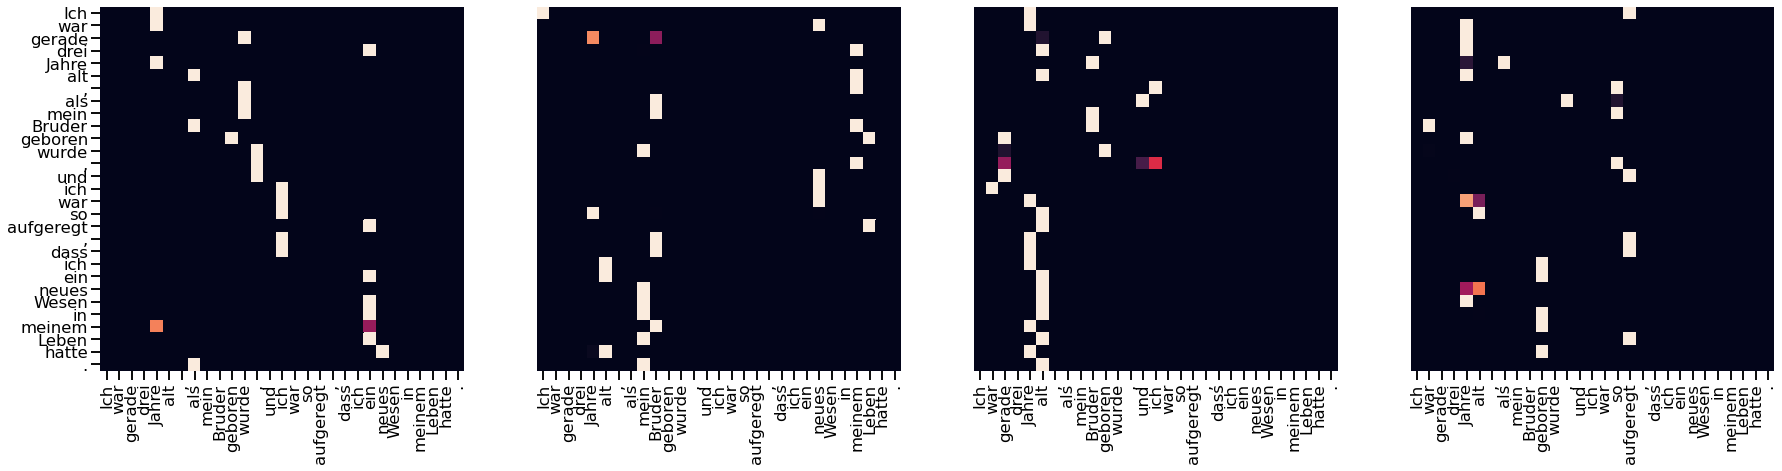

Encoder Layer 4


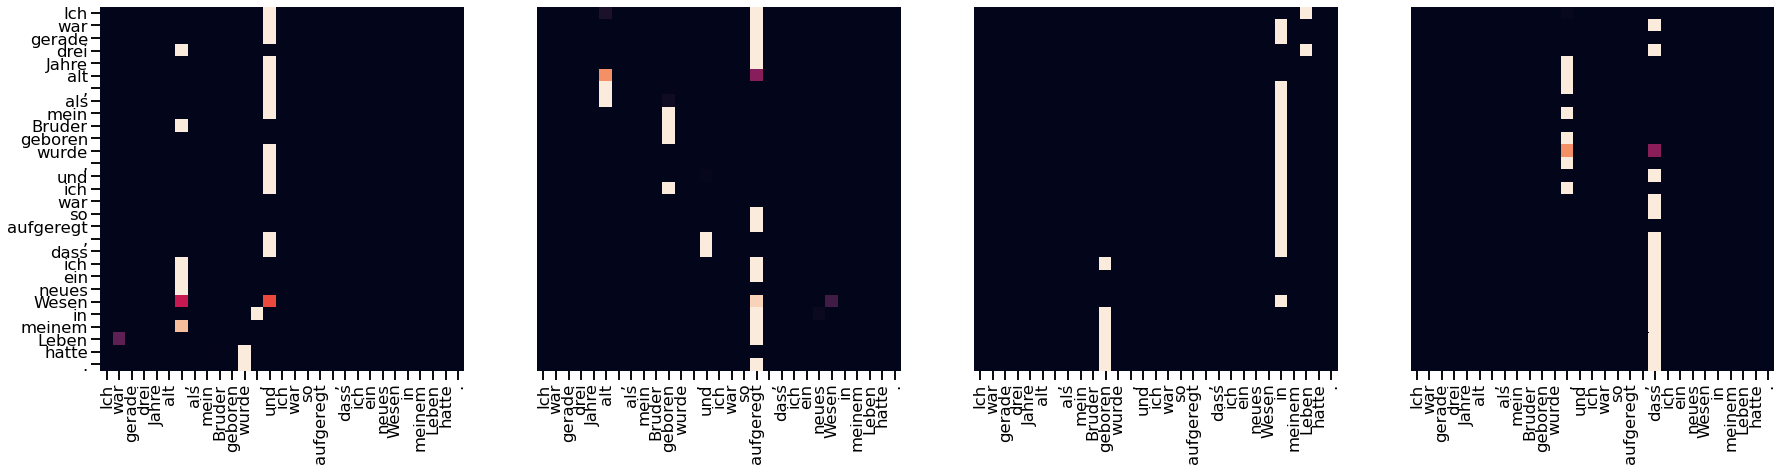

Encoder Layer 6


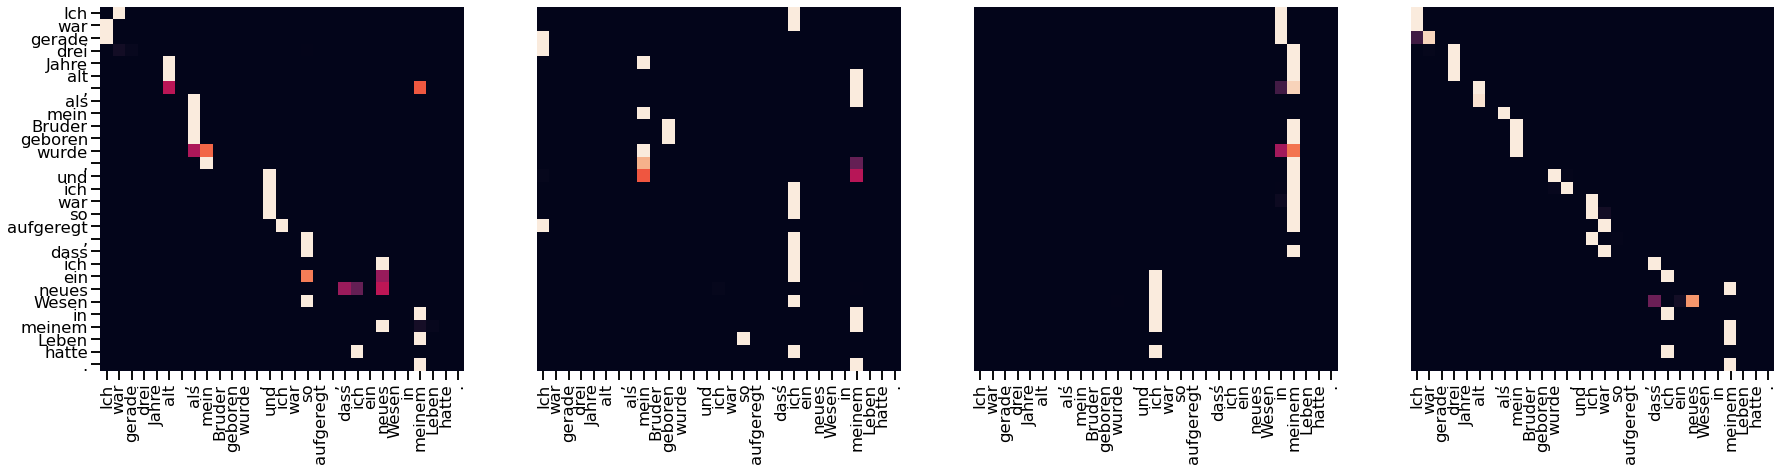

Decoder Layer 2


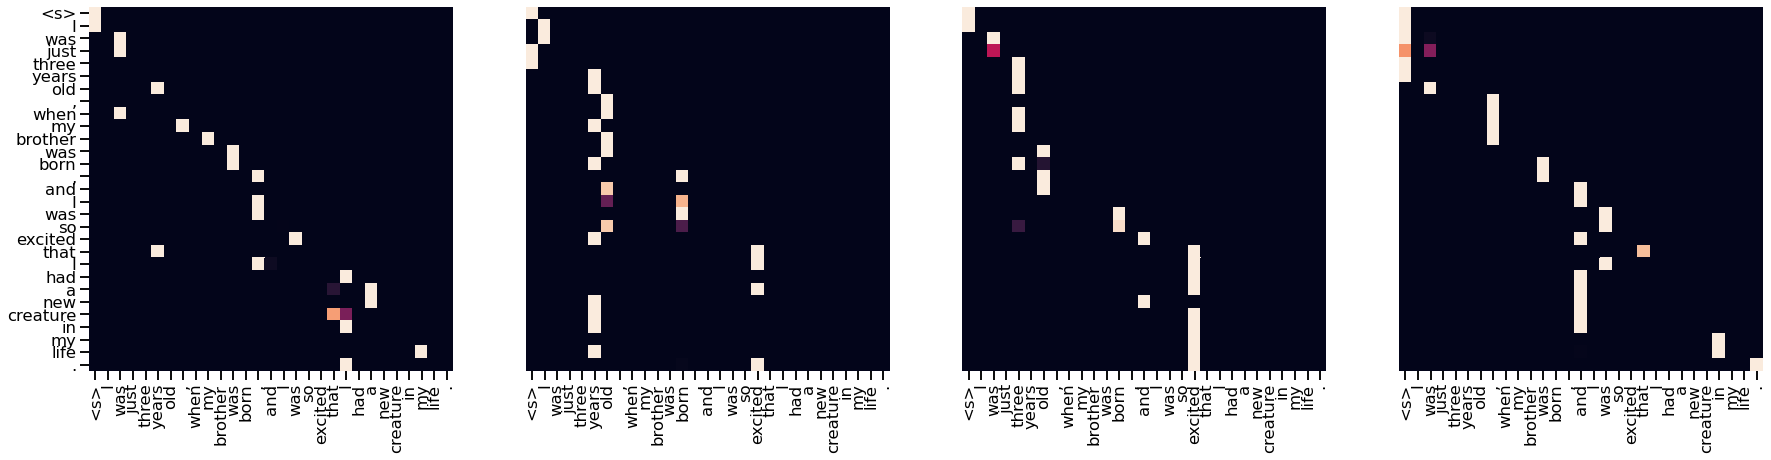

Decoder Layer 4


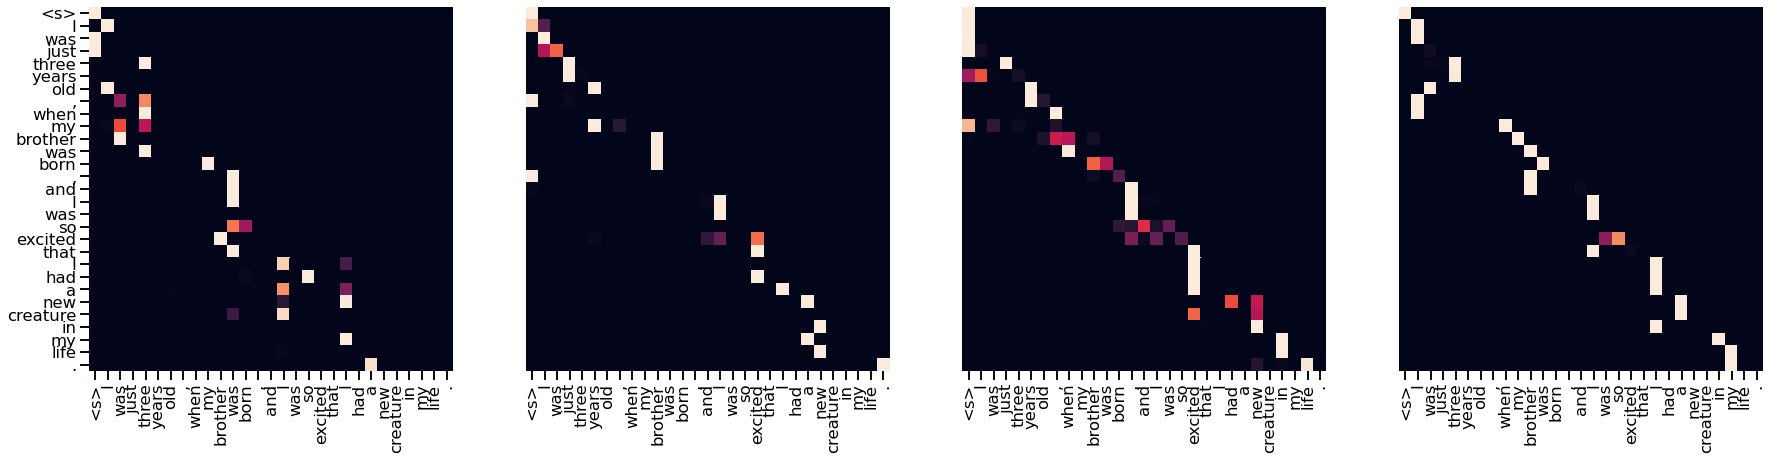

Decoder Layer 6


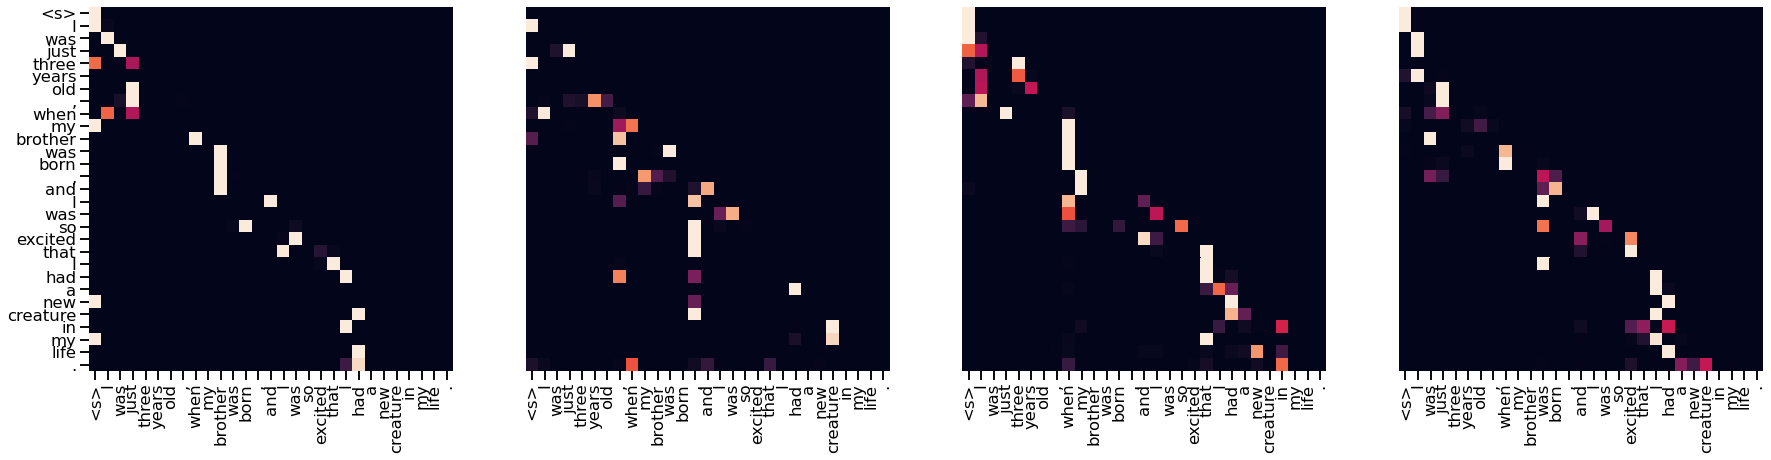

In [16]:
sent = [SRC.vocab.itos[w] for w in src[0]]
src = torch.LongTensor([[SRC.vocab.stoi[w] for w in sent]])
#src = Variable(src)
src = src.to(device)
src_mask = (src != SRC.vocab.stoi["<blank>"]).unsqueeze(-2)
out = greedy_decode(model, src, src_mask, 
                    max_len=60, start_symbol=TGT.vocab.stoi["<s>"])
print("Translation:", end="\t")
trans = "<s> "
for i in range(1, out.size(1)):
    sym = TGT.vocab.itos[out[0, i]]
    if sym == "</s>": break
    trans += sym + " "
print(trans)

tgt_sent = trans.split()
def draw(data, x, y, ax):
    seaborn.heatmap(data, 
                    xticklabels=x, square=True, yticklabels=y, vmin=0.0, vmax=1.0, 
                    cbar=False, ax=ax)
    
for layer in range(1, 6, 2):
    fig, axs = plt.subplots(1,4, figsize=(30, 15))
    print("Encoder Layer", layer+1)
    for h in range(4):
        draw(model.encoder.layers[layer].self_attn.attn[0, h].data.cpu(), 
            sent, sent if h ==0 else [], ax=axs[h])
    plt.show()
    
for layer in range(1, 6, 2):
    fig, axs = plt.subplots(1,4, figsize=(30, 15))
    print("Decoder Layer", layer+1)
    for h in range(4):
        draw(model.decoder.layers[layer].self_attn.attn[0, h].data[:len(tgt_sent), :len(tgt_sent)].cpu(), 
            tgt_sent, tgt_sent if h ==0 else [], ax=axs[h])
    plt.show()